In [75]:
import os
import numpy as np
import pandas as pd
from pathlib import Path
import matplotlib.pyplot as plt
from mdlearn.utils import plot_scatter
from typing import List, Dict

from Bio import SeqIO, SeqUtils, SeqRecord
from Bio.SeqUtils.IsoelectricPoint import IsoelectricPoint

os.environ["CUDA_VISIBLE_DEVICES"] = "2"

In [14]:
# TODO:
# Convert DNA to RNA and predict RNA secondary structure (Important for mRNA translation into protien)
# If the RNA can form stable secondary structures, you can get metastable structures which makes in difficiult
# for the ribosome to read the RNA, which slows down translation.

# Can also look at DNA secondary structure

# Can look at secondary strcuture prediction of protein and then can align the secondary strcutures

# DNA melting point (strongly correlated with GC) stronger if more GC's are grouped together

# Color by stop codon

In [15]:
import matplotlib.pyplot as plt
def show_scatter(data: np.ndarray, color: np.ndarray):
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')
    ax.set_facecolor('white')
    ff = ax.scatter(data[:, 0], data[:, 1], data[:, 2], c=color)
    plt.colorbar(ff)
    plt.show()

In [16]:
ls /homes/mzvyagin/MDH/perlmutter_data/

globalstep2850.fasta           inference-test-embeddings.npy
gpt2_embeddings.tar.gz         inference-train-embeddings.npy
gpt2_generated_embeddings.npy  inference-val-embeddings.npy


In [17]:
#train_embed = np.load("")
val_embed = np.load("/homes/mzvyagin/MDH/perlmutter_data/inference-val-embeddings.npy")
test_embed = np.load("/homes/mzvyagin/MDH/perlmutter_data/inference-test-embeddings.npy")
generated_embed = np.load("/homes/mzvyagin/MDH/perlmutter_data/gpt2_generated_embeddings.npy")

In [18]:
generated_embed.shape

(128, 512, 768)

In [19]:
val_embed.shape

(3664, 512, 768)

In [20]:
# Average residue dimension to get a single embedding per sequence
val_avg = val_embed.mean(axis=1)
test_avg = test_embed.mean(axis=1)
generated_avg = generated_embed.mean(axis=1)

In [21]:
val_avg.shape

(3664, 768)

In [22]:
p = Path("/homes/mzvyagin/MDH/gene_transformer/gene_transformer/data/full_mdh_fasta")

train_seqs = list(SeqIO.parse(p / "train.fasta", "fasta"))
val_seqs = list(SeqIO.parse(p / "val.fasta", "fasta"))
test_seqs = list(SeqIO.parse(p / "test.fasta", "fasta"))
generated_seqs = list(SeqIO.parse("/homes/mzvyagin/MDH/perlmutter_data/globalstep2850.fasta", "fasta"))

# Clip to embedding length
#train_seqs = train_seqs[:len(train_embed)]
val_seqs = val_seqs[:len(val_embed)]
test_seqs = test_seqs[:len(test_embed)]

train_protein_seq = [s.translate(to_stop=True) for s in train_seqs]
val_protein_seq = [s.translate(to_stop=True) for s in val_seqs]
test_protein_seq = [s.translate(to_stop=True) for s in test_seqs]
generated_protein_seqs = [s.translate(to_stop=True) for s in generated_seqs]

In [23]:
test_protein_seq[0]

SeqRecord(seq=Seq('MKVAVLGAAGGIGQALALLLKTQLPAGSKLSLYDIAPVTPGVAVDLSHIPTDVE...FVK'), id='<unknown id>', name='<unknown name>', description='<unknown description>', dbxrefs=[])

In [24]:
# Sequence metrics (scalar value per sequence)

def gc_content(seqs):
    return [SeqUtils.GC(rec.seq) for rec in seqs]

def seq_length(seqs):
    return [len(rec.seq) for rec in seqs]

def molecular_weight(seqs):
    return [SeqUtils.molecular_weight(rec.seq, "protein") for rec in seqs]

def isoelectric_point(seqs):
    return [IsoelectricPoint(seq).pi() for seq in seqs]

train_paint_df = pd.DataFrame({
        "GC": gc_content(train_seqs),
        "SequenceLength": seq_length(train_seqs),
        "MolecularWeight": molecular_weight(train_seqs),
        "IsoelectricPoint": isoelectric_point(train_protein_seq),
})

val_paint_df = pd.DataFrame({
        "GC": gc_content(val_seqs),
        "SequenceLength": seq_length(val_seqs),
        "MolecularWeight": molecular_weight(val_protein_seq),
        "IsoelectricPoint": isoelectric_point(val_protein_seq),
})

test_paint_df = pd.DataFrame({
        "GC": gc_content(test_seqs),
        "SequenceLength": seq_length(test_seqs),
        "MolecularWeight": molecular_weight(test_protein_seq),
        "IsoelectricPoint": isoelectric_point(test_protein_seq),
})

generated_paint_df = pd.DataFrame({
        "GC": gc_content(generated_seqs),
        "SequenceLength": seq_length(generated_seqs),
        "MolecularWeight": molecular_weight(generated_protein_seqs),
        "IsoelectricPoint": isoelectric_point(generated_protein_seqs),
})

In [12]:
train_paint_df.corr()

GC  SequenceLength  MolecularWeight  IsoelectricPoint
GC                1.000000        0.265624         0.276833          0.047922
SequenceLength    0.265624        1.000000         0.975473          0.254085
MolecularWeight   0.276833        0.975473         1.000000          0.237541
IsoelectricPoint  0.047922        0.254085         0.237541          1.000000

In [13]:
val_paint_df.corr()

GC  SequenceLength  MolecularWeight  IsoelectricPoint
GC                1.000000        0.260735         0.083411          0.041451
SequenceLength    0.260735        1.000000         0.895989          0.246249
MolecularWeight   0.083411        0.895989         1.000000          0.247115
IsoelectricPoint  0.041451        0.246249         0.247115          1.000000

In [14]:
test_paint_df.corr()

GC  SequenceLength  MolecularWeight  IsoelectricPoint
GC                1.000000        0.276797         0.108882          0.044267
SequenceLength    0.276797        1.000000         0.935294          0.231844
MolecularWeight   0.108882        0.935294         1.000000          0.264127
IsoelectricPoint  0.044267        0.231844         0.264127          1.000000

In [15]:
generated_paint_df.corr()

GC  SequenceLength  MolecularWeight  IsoelectricPoint
GC                1.000000        0.754317         0.530526          0.385670
SequenceLength    0.754317        1.000000         0.859658          0.706478
MolecularWeight   0.530526        0.859658         1.000000          0.894860
IsoelectricPoint  0.385670        0.706478         0.894860          1.000000

array([[<AxesSubplot:title={'center':'GC'}>,
        <AxesSubplot:title={'center':'SequenceLength'}>],
       [<AxesSubplot:title={'center':'MolecularWeight'}>,
        <AxesSubplot:title={'center':'IsoelectricPoint'}>]], dtype=object)

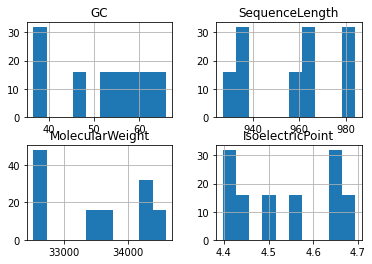

In [39]:
generated_paint_df.hist()

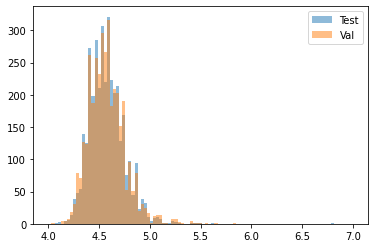

In [61]:
bins = np.linspace(4, 7, 100)

plt.hist(test_paint_df["IsoelectricPoint"], bins, alpha=0.5, label='Test')
plt.hist(val_paint_df["IsoelectricPoint"][:-1], bins, alpha=0.5, label='Val')
plt.legend(loc='upper right')
plt.title("Isoelectric Point")
plt.show()

In [40]:
plot_scatter(generated_avg[:, 0:0+3], {"gc": generated_paint_df.GC[:3656]}, "gc")

In [19]:
plot_scatter(test_avg[:, 0:0+3], {"gc": test_paint_df.GC[:3656]}, "gc")

In [25]:
def run_tsne(data: np.ndarray):
        
    # Attempt to use rapidsai
    from cuml.manifold import TSNE
    
    # rapidsai only supports 2 dimensions
    model = TSNE(n_components=2, method="barnes_hut")
    
    data_proj = model.fit_transform(data)
    return data_proj
    
def plot_tsne(data_proj: np.ndarray, paint: np.ndarray, paint_name: str, cmap: str = "viridis"):
    df = pd.DataFrame({"z0": data_proj[:, 0], "z1": data_proj[:, 1], paint_name: paint[:data_proj.shape[0]]})
    ax2 = df.plot.scatter(x='z0', y='z1',c=paint_name, colormap=cmap, alpha=0.4)
    plt.show()
    return df
    

In [50]:
840 / 3, 1050 / 3

(280.0, 350.0)

In [ ]:
# TODO: Grab two from each cluster and run through alphafold

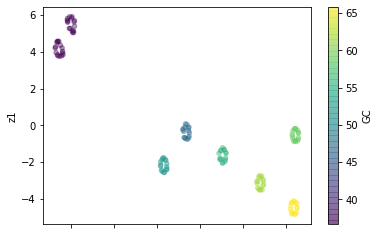

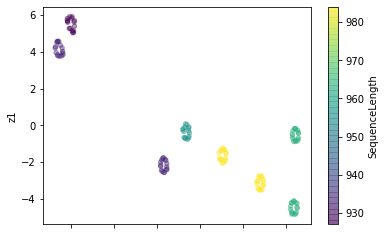

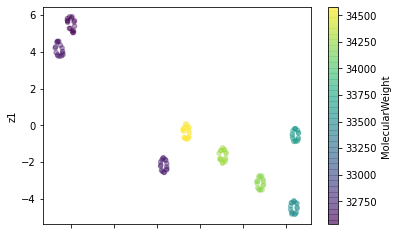

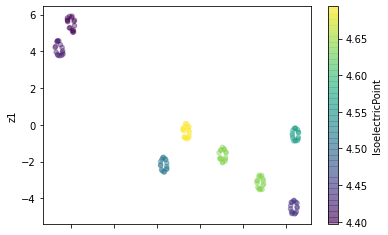

In [37]:
generated_tsne = run_tsne(generated_avg)
for key in test_paint_df:
    gen_df = plot_tsne(generated_tsne, generated_paint_df[key], key, cmap="viridis")

# Select cluster prototypes for generated sequences

In [28]:
from sklearn.cluster import KMeans
# Use 8 clusters as seen in t-SNE
kmeans = KMeans(n_clusters=8, random_state=0).fit(generated_avg)

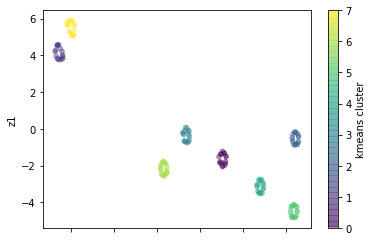

In [38]:
gen_df = plot_tsne(generated_tsne, kmeans.labels_, "kmeans cluster", cmap="viridis")

In [44]:
generated_avg.shape

(128, 768)

In [47]:
kmeans.cluster_centers_.shape

(8, 768)

In [83]:
def get_cluster_prototypes(generated_avg, kmeans, k: int = 2) -> Dict[int, List[int]]:
    results = {}
    inds = np.arange(len(generated_avg))
    for label in np.unique(kmeans.labels_):
        mask = kmeans.labels_ == label
        generated_inds = inds[mask]
        generated_cluster = generated_avg[mask]
        # Recompute cluster center incase of numerical issues
        # Should be the same as kmeans.cluster_centers_[label]
        center = np.mean(generated_cluster, axis=0).reshape(1, -1)
        dists = np.linalg.norm(center - generated_cluster, axis=1)
        top_k = np.argpartition(dists, kth=k)
        results[label] = generated_inds[top_k[:k]]
    return results

In [77]:
# Pick 2 points in each cluster that are closest to the kmeans cluster centroid
prototypes = get_cluster_prototypes(generated_avg, kmeans)

In [78]:
prototypes

{0: array([36, 68]),
 1: array([29, 61]),
 2: array([121, 105]),
 3: array([ 62, 126]),
 4: array([115,  91]),
 5: array([55, 39]),
 6: array([ 58, 122]),
 7: array([96, 40])}

In [81]:
prototype_seqs = {key: [generated_protein_seqs[ind] for ind in val]  for key, val in prototypes.items()}

In [92]:
record_dir = Path("synthetic_seqeunces")
record_dir.mkdir(exist_ok=True)
for key, seqs in prototype_seqs.items():
    inds = prototypes[key]
    for seq, ind in zip(seqs, inds):
        seq.id = f"MDH_SyntheticSeq_cluster_prototype_{key}_index_{ind}"
        seq.name="MDH_sequence",
        seq.description="synthetic malate dehydrogenase"
        SeqIO.write(seq, record_dir / f"MDH_synthetic_cluster_prototype_{key}_index_{ind}.fasta", "fasta")

# Visualization of testing embeddings

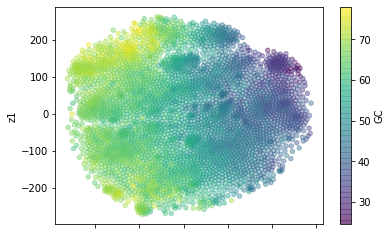

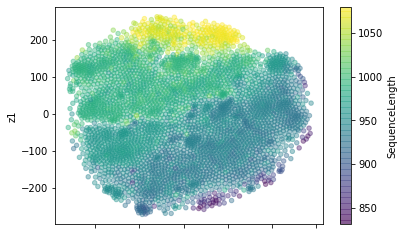

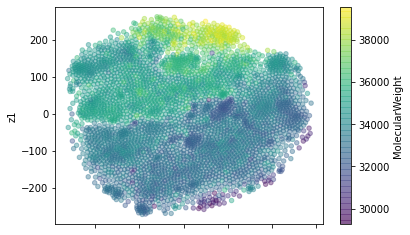

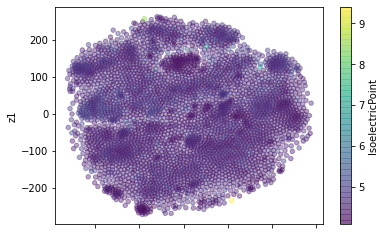

In [21]:
test_tsne = run_tsne(test_avg)
for key in test_paint_df:
    test_df = plot_tsne(test_tsne, test_paint_df[key], key, cmap="viridis")

In [30]:
test_tsne.shape

(3656, 2)

In [31]:
len(test_paint_df)

3663

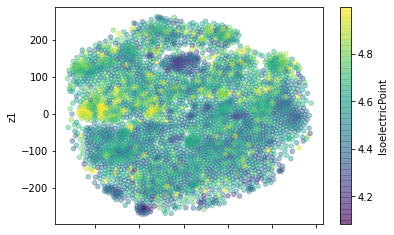

z0          z1  IsoelectricPoint
0      93.652779   27.135876          4.596876
1      -1.260765   65.989990          4.789219
2     -39.771744  256.041779          4.565047
3     103.657242  -40.620667          4.739144
4    -142.672791    0.496575          4.639790
...          ...         ...               ...
3651 -205.316818   16.202179          4.721013
3652  -35.638569   63.634506          4.544016
3653   42.522263  242.476776          4.650760
3654  -39.058228 -126.116982          4.346103
3655 -249.425446  103.632706          4.477458

[3598 rows x 3 columns]

In [22]:
key = "IsoelectricPoint"
iso_slice = (test_paint_df[key] < 5).values
plot_tsne(test_tsne[iso_slice], test_paint_df[key][iso_slice], key, cmap="viridis")

In [27]:
test_tsne.shape

(3656, 2)

# Visualization of validation embeddings

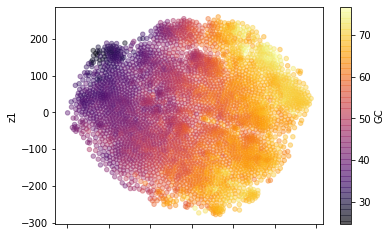

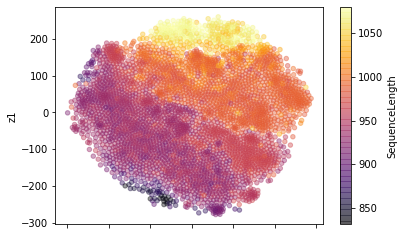

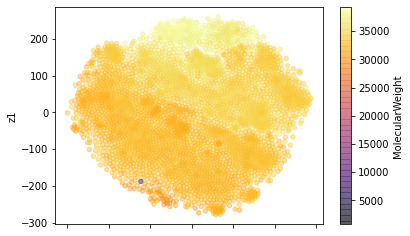

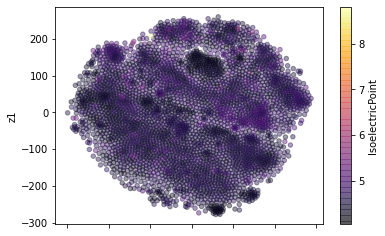

In [23]:
val_tsne = run_tsne(val_avg)
for key in val_paint_df:
    val_df = plot_tsne(val_tsne, val_paint_df[key], key, cmap="inferno")

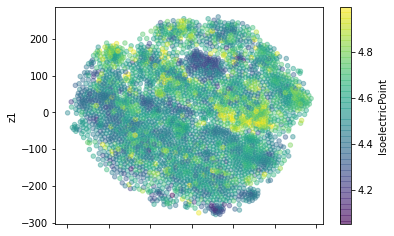

z0          z1  IsoelectricPoint
0     -29.023035 -199.177872          4.677531
1     202.304504 -110.283623          4.678554
2    -122.526016   -1.480024          4.568286
3    -197.423218    2.941145          4.621317
4     147.032425  -97.447937          4.671506
...          ...         ...               ...
3659  119.619316  -16.484837          4.857654
3660  230.599380 -106.224792          4.538105
3661  155.596039  -18.346693          4.750796
3662   77.025986   -7.941111          4.964738
3663  136.265656  200.305725          4.458814

[3581 rows x 3 columns]

In [24]:
key = "IsoelectricPoint"
iso_slice = (val_paint_df[key] < 5).values
plot_tsne(val_tsne[iso_slice], val_paint_df[key][iso_slice], key, cmap="viridis")

In [7]:
from Bio import pairwise2
from tqdm import tqdm
from concurrent.futures import ProcessPoolExecutor

def compute_alignment_scores(kwargs: dict):
    # Input arguments to parallel function    
    target_seq = kwargs.get("target_seq")
    seqs = kwargs.get("seqs")
    alignment_type = kwargs.get("alignment_type")
    
    if alignment_type == "global":
        aligner = pairwise2.align.globalxx
    elif alignment_type == "local":
        aligner = pairwise2.align.localxx
    else:
        raise ValueError(f"Invalid alignment_type: {alignment_type}")
        
    scores = np.array([
        aligner(target_seq, seq, score_only=True)
        for seq in seqs
    ])
    return scores

def alignment_scores_parallel(
    seqs1: List[SeqRecord.SeqRecord],
    seqs2: List[SeqRecord.SeqRecord],
    alignment_type: str = "global",
    num_workers: int = 1
):
    """Computes all pairwise alignments scores between sequences 
    in seqs1 and seqs2"""
    
    kwargs = [
        {
            "target_seq": seq,
            "seqs": seqs2,
            "alignment_type": alignment_type,
        }
        for seq in seqs1 
    ]
    
    scores_matrix = []
    with ProcessPoolExecutor(max_workers=num_workers) as executor:
        for scores in tqdm(executor.map(compute_alignment_scores, kwargs)):
            scores_matrix.append(scores)
    return np.array(scores_matrix)

In [8]:
test_alignment_scores = alignment_scores_parallel(test_protein_seq, test_protein_seq, num_workers=70)

3656it [01:56, 31.41it/s]


In [71]:
test_local_alignment_scores = alignment_scores_parallel(
    test_protein_seq, test_protein_seq, alignment_type="local", num_workers=70
)

3656it [02:10, 28.08it/s]


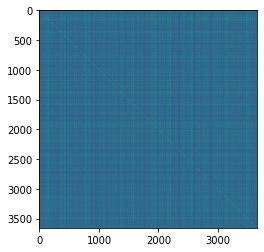

In [54]:
plt.imshow(test_alignment_scores)

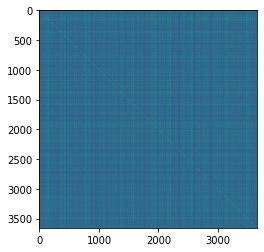

In [72]:
plt.imshow(test_local_alignment_scores)

In [12]:
from scipy.spatial import distance_matrix

In [13]:
test_emb_dist = distance_matrix(test_avg, test_avg)

In [14]:
test_emb_dist.shape

(3656, 3656)

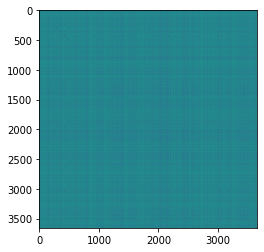

In [55]:
plt.imshow(test_emb_dist)

In [15]:
test_emb_dist_upper = np.triu(test_emb_dist).flatten()
test_emb_dist_upper = test_emb_dist_upper[test_emb_dist_upper > 0]

# need to subtract of diagonal since alignment scores between the same seqeunce will be large positive values
test_alignment_scores_upper = np.triu(test_alignment_scores - np.diag(np.diag(test_alignment_scores))).flatten()
test_alignment_scores_upper = test_alignment_scores_upper[test_alignment_scores_upper > 0]

# need to subtract of diagonal since alignment scores between the same seqeunce will be large positive values
# test_local_alignment_scores_upper = np.triu(test_local_alignment_scores - np.diag(np.diag(test_local_alignment_scores))).flatten()
# test_local_alignment_scores_upper = test_local_alignment_scores_upper[test_local_alignment_scores_upper > 0]

print(test_emb_dist_upper.shape)
print(test_alignment_scores_upper.shape)

scores_df = pd.DataFrame({
    "Embedding L2 Distance": test_emb_dist_upper,
    "Global Alignment Score": test_alignment_scores_upper,
    #"Local Alignment Score": test_local_alignment_scores_upper,
})

(6681340,)
(6681340,)


In [16]:
unique_scores = scores_df["Global Alignment Score"].unique()

In [17]:
unique_scores

array([151., 148., 153., 154., 155., 147., 149., 152., 150., 156., 168.,
       145., 158., 157., 159., 181., 176., 174., 178., 182., 177., 146.,
       180., 171., 160., 179., 175., 173., 144., 172., 184., 169., 183.,
       164., 143., 167., 162., 166., 165., 163., 170., 161., 142., 141.,
       185., 140., 138., 139., 137.])

In [86]:
scores_df

Embedding L2 Distance  Global Alignment Score  Local Alignment Score
0                     0.061166                   151.0                  151.0
1                     0.089407                   148.0                  148.0
2                     0.037864                   153.0                  153.0
3                     0.078016                   154.0                  154.0
4                     0.056320                   155.0                  155.0
...                        ...                     ...                    ...
6681335               0.058759                   151.0                  151.0
6681336               0.062153                   162.0                  162.0
6681337               0.072231                   145.0                  145.0
6681338               0.080624                   146.0                  146.0
6681339               0.062995                   154.0                  154.0

[6681340 rows x 3 columns]

In [24]:
score_avg_dist = [
    np.mean(scores_df["Embedding L2 Distance"][scores_df["Global Alignment Score"] == score])
    for score in sorted(unique_scores)
]

score_stdev_dist = [
    np.std(scores_df["Embedding L2 Distance"][scores_df["Global Alignment Score"] == score])
    for score in sorted(unique_scores)
]

In [40]:
score_avg_df = pd.DataFrame({
    "avg_emb": score_avg_dist,
    "stdev_emb": score_stdev_dist,
    "align_score": sorted(unique_scores)
})

score_avg_df.corr()

avg_emb  stdev_emb  align_score
avg_emb      1.000000  -0.020068    -0.941217
stdev_emb   -0.020068   1.000000    -0.189469
align_score -0.941217  -0.189469     1.000000

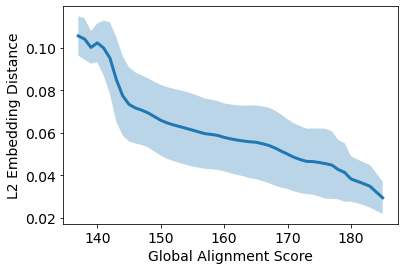

In [42]:
lower_bound = score_avg_df.avg_emb - score_avg_df.stdev_emb
upper_bound = score_avg_df.avg_emb + score_avg_df.stdev_emb
plt.plot(score_avg_df.align_score, score_avg_df.avg_emb, linewidth=3)
plt.ylabel("L2 Embedding Distance", fontsize=14)
plt.xlabel("Global Alignment Score", fontsize=14)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.fill_between(score_avg_df.align_score, lower_bound, upper_bound, alpha=.3)

<AxesSubplot:xlabel='Global Alignment Score', ylabel='Embedding L2 Distance'>

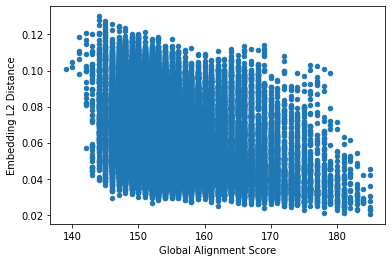

In [80]:
scores_df[::100].plot.scatter(y="Embedding L2 Distance", x="Global Alignment Score")

<AxesSubplot:xlabel='Local Alignment Score', ylabel='Embedding L2 Distance'>

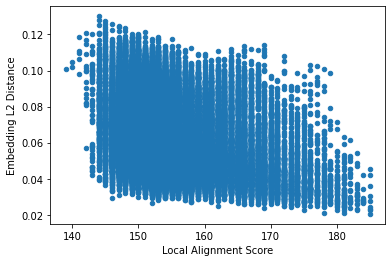

In [82]:
scores_df[::100].plot.scatter(y="Embedding L2 Distance", x="Local Alignment Score")

In [74]:
scores_df.corr()

Embedding L2 Distance  Global Alignment Score  \
Embedding L2 Distance                1.000000               -0.289023   
Global Alignment Score              -0.289023                1.000000   
Local ALignment Score               -0.289023                1.000000   

                        Local ALignment Score  
Embedding L2 Distance               -0.289023  
Global Alignment Score               1.000000  
Local ALignment Score                1.000000